In [45]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2 as cv
# import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from PIL import Image
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [46]:
from zipfile import ZipFile
file_name = "dataset.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [47]:
from zipfile import ZipFile
file_name = "datatest.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [48]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [49]:
df = pd.read_csv("features.csv")
dt = pd.read_csv("Data_test.csv")
df.head()

,Unnamed: 0,Energy_0,Corr_0,Homogen_0,Contrast_0,ASM_0,Energy_45,Corr_45,Homogen_45,Contrast_45,...,Homogen_90,Contrast_90,ASM_90,Energy_135,Corr_135,Homogen_135,Contrast_135,ASM_135,output,filenames
0,0,0.360166,0.849100,0.715262,400.557698,0.129720,0.352685,0.830636,0.695192,449.911262,...,0.697137,444.862077,0.129720,0.371847,0.867505,0.744380,352.059009,0.129720,0,dataset\0\fish_0.jpg
1,0,0.400987,0.812333,0.749640,407.428869,0.160791,0.408181,0.835459,0.768635,358.929444,...,0.721557,478.110919,0.160791,0.392616,0.782994,0.729269,473.488716,0.160791,0,dataset\0\fish_1.jpg
2,0,0.376491,0.877119,0.798621,690.161206,0.141746,0.378780,0.881331,0.804157,665.580926,...,0.821744,582.173172,0.141746,0.374711,0.873295,0.793183,711.160952,0.141746,0,dataset\0\fish_10.jpg
3,0,0.348277,0.832274,0.694796,652.404336,0.121297,0.349204,0.834127,0.699276,647.042470,...,0.707651,618.055012,0.121297,0.360706,0.865813,0.734265,523.300701,0.121297,0,dataset\0\fish_11.jpg
4,0,0.362457,0.895325,0.755612,431.792027,0.131375,0.321500,0.830256,0.627472,697.592628,...,0.627253,695.672415,0.131375,0.325453,0.848361,0.642111,623.203608,0.131375,0,dataset\0\fish_12.jpg


In [50]:
df.drop(['filenames'], axis=1, inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Energy_0,Corr_0,Homogen_0,Contrast_0,ASM_0,Energy_45,Corr_45,Homogen_45,Contrast_45,ASM_45,...,Corr_90,Homogen_90,Contrast_90,ASM_90,Energy_135,Corr_135,Homogen_135,Contrast_135,ASM_135,output
0,0.360166,0.849100,0.715262,400.557698,0.129720,0.352685,0.830636,0.695192,449.911262,0.129720,...,0.832495,0.697137,444.862077,0.129720,0.371847,0.867505,0.744380,352.059009,0.129720,0
1,0.400987,0.812333,0.749640,407.428869,0.160791,0.408181,0.835459,0.768635,358.929444,0.160791,...,0.781798,0.721557,478.110919,0.160791,0.392616,0.782994,0.729269,473.488716,0.160791,0
2,0.376491,0.877119,0.798621,690.161206,0.141746,0.378780,0.881331,0.804157,665.580926,0.141746,...,0.896054,0.821744,582.173172,0.141746,0.374711,0.873295,0.793183,711.160952,0.141746,0
3,0.348277,0.832274,0.694796,652.404336,0.121297,0.349204,0.834127,0.699276,647.042470,0.121297,...,0.842687,0.707651,618.055012,0.121297,0.360706,0.865813,0.734265,523.300701,0.121297,0
4,0.362457,0.895325,0.755612,431.792027,0.131375,0.321500,0.830256,0.627472,697.592628,0.131375,...,0.830514,0.627253,695.672415,0.131375,0.325453,0.848361,0.642111,623.203608,0.131375,0


In [51]:
label_distr = df['output'].value_counts()

label_name = ['Normal', 'RS', 'MAS', 'WS']

print(label_distr)

1    27
0    26
2    16
3    14
Name: output, dtype: int64


In [52]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [53]:
def decimal_scaling(data):
    data = np.array(data, dtype=np.float32)
    max_row = data.max(axis=0)
    c = np.array([len(str(int(number))) for number in np.abs(max_row)])
    return data / (10 ** c)


X = decimal_scaling(df[['Energy_0', 'Corr_0', 'Homogen_0', 'Contrast_0', 'ASM_0',
                        'Energy_45', 'Corr_45', 'Homogen_45', 'Contrast_45', 'ASM_45',
                        'Energy_90', 'Corr_90', 'Homogen_90', 'Contrast_90', 'ASM_90',
                        'Energy_135', 'Corr_135', 'Homogen_135', 'Contrast_135', 'ASM_135']].values)

In [54]:
le = LabelEncoder()
le.fit(df["output"].values)

print(" categorical label : \n", le.classes_)

Y = le.transform(df['output'].values)
Y = to_categorical(Y)

print("\n\n one hot encoding for sample 0 : \n", Y[0])

 categorical label : 
 [0 1 2 3]


 one hot encoding for sample 0 : 
 [1. 0. 0. 0.]


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2,random_state=42)

print("Dimensi data :\n")
print("X train \t X test \t Y train \t Y test")
print("%s \t %s \t %s \t %s" % (X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Dimensi data :

X train 	 X test 	 Y train 	 Y test
(66, 20) 	 (17, 20) 	 (66, 4) 	 (17, 4)


In [56]:
from keras.models import Sequential
from keras.layers import Dense, Activation

import keras
from keras import backend as K

In [57]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def nn_model(max_len):
    model = Sequential()
    model.add(Dense(32,
                    activation="elu",
                    input_shape=(max_len,)))
    model.add(Dense(128, activation="elu"))
    model.add(Dense(64, activation="elu"))
    model.add(Dense(32, activation="elu"))
    model.add(Dense(16, activation="elu"))
    model.add(Dense(4))
    model.add(Activation("sigmoid"))

    model.summary()

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', precision, recall])
    return model


def check_model(model_, x, y, x_val, y_val, epochs_, batch_size_):
    hist = model_.fit(x,
                      y,
                      epochs=epochs_,
                      batch_size=batch_size_,
                      validation_data=(x_val, y_val))
    return hist

In [58]:
max_len = X_train.shape[1]

EPOCHS = 500
BATCH_SIZE = 32

model = nn_model(max_len)
history = check_model(model, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                672       
                                                                 
 dense_7 (Dense)             (None, 128)               4224      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
 activation_1 (Activation)   (None, 4)                

In [59]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.head(500)

,epoch,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,1,1.384475,0.303030,0.312500,0.177414,1.351782,0.352941,0.764706,0.382353
1,2,1.362787,0.348485,0.427083,0.211699,1.328585,0.352941,0.705882,0.363636
2,3,1.348565,0.333333,0.729167,0.369261,1.328346,0.352941,0.764706,0.382353
3,4,1.344986,0.333333,0.385417,0.207273,1.324584,0.352941,0.705882,0.363636
4,5,1.337576,0.333333,0.697917,0.364176,1.327833,0.352941,0.705882,0.363636
...,...,...,...,...,...,...,...,...,...
495,496,0.755570,0.666667,0.958333,0.435052,0.499447,0.764706,1.000000,0.435897
496,497,0.731928,0.727273,0.802083,0.358219,0.480451,0.705882,1.000000,0.435897
497,498,0.697359,0.681818,0.958333,0.407357,0.536825,0.705882,1.000000,0.435897
498,499,0.744342,0.696970,0.968750,0.408378,0.571141,0.647059,1.000000,0.459459


In [60]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
484,485,0.720052,0.681818,0.958333,0.398817,0.445988,0.764706,1.0,0.435897


In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                672       
                                                                 
 dense_7 (Dense)             (None, 128)               4224      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
 activation_1 (Activation)   (None, 4)                

In [62]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [63]:
 # predict test data
y_pred= model.predict(X_test)
print(y_pred)

[[4.74e-01 5.15e-01 6.16e-01 2.16e-01]
 [7.83e-01 7.47e-01 1.16e-01 7.41e-01]
 [9.67e-01 7.40e-01 3.92e-02 4.06e-01]
 [1.74e-01 5.74e-01 7.98e-01 1.18e-01]
 [9.78e-01 8.52e-01 1.42e-02 6.44e-01]
 [6.93e-01 6.91e-01 2.21e-01 4.14e-01]
 [9.92e-01 9.58e-01 2.73e-03 7.05e-01]
 [1.09e-01 7.92e-01 7.70e-01 8.18e-03]
 [9.86e-01 9.13e-01 7.00e-03 6.12e-01]
 [9.96e-01 9.75e-01 1.13e-03 7.98e-01]
 [2.79e-01 7.57e-01 7.79e-01 1.93e-02]
 [3.87e-03 9.98e-01 8.60e-01 2.72e-06]
 [4.26e-01 4.72e-01 4.68e-01 4.39e-01]
 [1.11e-01 8.95e-01 7.60e-01 2.20e-03]
 [1.04e-01 6.11e-01 7.54e-02 1.00e+00]
 [1.22e-01 8.93e-01 7.58e-01 1.78e-03]
 [8.00e-01 6.47e-01 5.50e-02 9.37e-01]]


In [64]:
predict = []
for i in range(0, 16):
    predict.append(max(y_pred[i]))
predict

[0.61581564,
 0.7831664,
 0.9671242,
 0.7984506,
 0.978135,
 0.6932492,
 0.99156165,
 0.7917658,
 0.9863403,
 0.99583274,
 0.7785554,
 0.99846494,
 0.4716571,
 0.89506555,
 0.9997823,
 0.89313626]

In [65]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

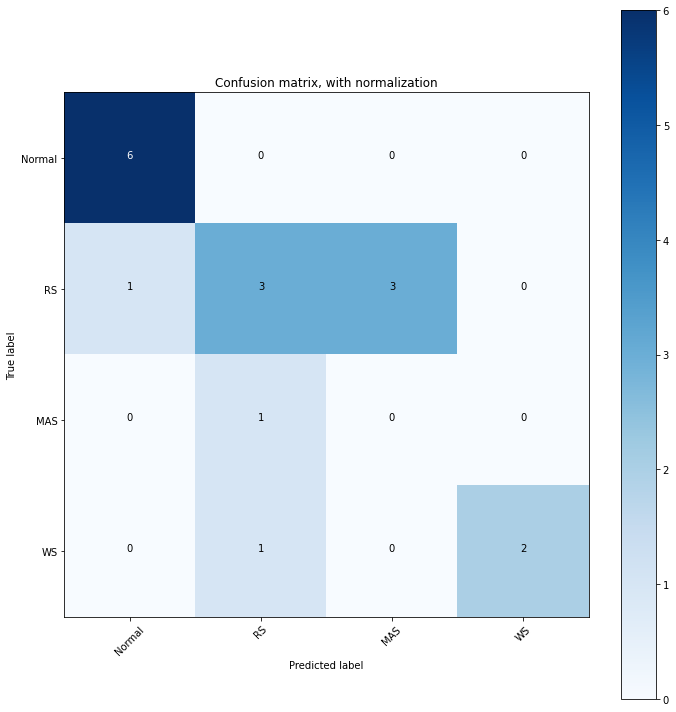

In [66]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix,
                      classes=['Normal', 'RS', 'MAS', 'WS'],
                      normalize=False,
                      title='Confusion matrix, with normalization')

In [67]:
print(classification_report(y_test.argmax(axis=1),
                            y_pred.argmax(axis=1),
                            target_names=['Normal', 'RS', 'MAS', 'WS']))

              precision    recall  f1-score   support

      Normal       0.86      1.00      0.92         6
          RS       0.60      0.43      0.50         7
         MAS       0.00      0.00      0.00         1
          WS       1.00      0.67      0.80         3

    accuracy                           0.65        17
   macro avg       0.61      0.52      0.56        17
weighted avg       0.73      0.65      0.67        17



In [68]:
ytest = dt['output']
xtest = dt.drop(columns=['Unnamed: 0', 'output', 'filenames'])
xtest = preprocessing.StandardScaler().fit(xtest).transform(xtest.astype(float))
dt.head()

,Unnamed: 0,Energy_0,Corr_0,Homogen_0,Contrast_0,ASM_0,Energy_45,Corr_45,Homogen_45,Contrast_45,...,Homogen_90,Contrast_90,ASM_90,Energy_135,Corr_135,Homogen_135,Contrast_135,ASM_135,output,filenames
0,0,0.238833,0.517603,0.412533,3069.396847,0.057041,0.232840,0.481561,0.384189,3294.214195,...,0.379124,3528.956028,0.057041,0.242723,0.514698,0.431989,3083.943518,0.057041,0,dataset/0/fish_0.jpg
1,0,0.238353,0.512358,0.413436,3262.862123,0.056812,0.242940,0.525515,0.433085,3173.205623,...,0.367355,3774.753721,0.056812,0.230253,0.464397,0.376618,3582.181970,0.056812,0,dataset/0/fish_1.jpg
2,0,0.259169,0.445380,0.457163,3189.128320,0.067168,0.262902,0.466383,0.471457,3070.517608,...,0.523060,2503.627934,0.067168,0.263560,0.471281,0.475134,3042.272336,0.067168,0,dataset/0/fish_3.jpg
3,0,0.269625,0.548643,0.496141,3177.300241,0.072697,0.252457,0.419631,0.438557,4074.419555,...,0.421847,4255.804873,0.072697,0.251784,0.413907,0.434164,4114.603695,0.072697,0,dataset/0/fish_2.jpg
4,0,0.262031,0.443838,0.461995,3248.030262,0.068660,0.266288,0.473357,0.478816,3078.603990,...,0.577084,2064.272280,0.068660,0.269411,0.490361,0.489698,2979.088552,0.068660,0,dataset/0/fish_6.jpg


In [69]:
le = LabelEncoder()
le.fit(dt["output"].values)

print(" categorical label : \n", le.classes_)

y2 = le.transform(dt['output'].values)
y2 = to_categorical(y2)

print("\n\n one hot encoding for sample 0 : \n", y2[0])

 categorical label : 
 [0 1 2 3]


 one hot encoding for sample 0 : 
 [1. 0. 0. 0.]


In [70]:
y2test = y2

In [71]:
xtest.shape, y2test.shape

((81, 20), (81, 4))

In [72]:
from sklearn.metrics import accuracy_score

In [73]:
ypredict = model.predict(xtest)
print(ypredict)

[[7.13e-11 5.80e-01 2.31e-01 1.00e+00]
 [3.12e-19 1.15e-04 1.00e+00 1.00e+00]
 [8.85e-01 1.00e+00 6.25e-23 1.00e+00]
 [1.00e+00 1.00e+00 0.00e+00 1.00e+00]
 [2.68e-01 1.00e+00 7.91e-22 1.00e+00]
 [7.72e-09 1.00e+00 9.80e-01 1.81e-13]
 [1.00e+00 1.00e+00 2.34e-24 1.00e+00]
 [1.00e+00 1.00e+00 0.00e+00 1.00e+00]
 [9.63e-01 1.00e+00 4.05e-23 1.00e+00]
 [1.00e+00 1.00e+00 0.00e+00 1.00e+00]
 [1.03e-12 1.00e+00 9.98e-01 1.04e-33]
 [1.00e+00 1.00e+00 2.28e-30 1.00e+00]
 [9.84e-01 1.00e+00 8.86e-01 2.55e-15]
 [1.95e-15 1.00e+00 9.99e-01 3.10e-11]
 [3.22e-27 1.81e-02 1.00e+00 1.00e+00]
 [1.00e+00 1.00e+00 0.00e+00 1.00e+00]
 [2.27e-37 1.00e+00 1.00e+00 4.27e-03]
 [1.17e-35 1.00e+00 1.00e+00 2.46e-06]
 [2.59e-06 1.00e+00 9.95e-01 0.00e+00]
 [5.86e-25 1.00e+00 1.00e+00 4.23e-01]
 [6.75e-08 1.00e+00 2.52e-18 1.00e+00]
 [1.00e+00 1.00e+00 2.42e-38 1.00e+00]
 [1.12e-15 1.00e+00 1.60e-06 1.00e+00]
 [1.00e+00 1.00e+00 0.00e+00 1.00e+00]
 [3.26e-29 1.45e-01 1.00e+00 1.00e+00]
 [5.35e-23 1.00e+00 1.00e

In [74]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y2test.argmax(axis=1), ypredict.argmax(axis=1))
np.set_printoptions(precision=2)

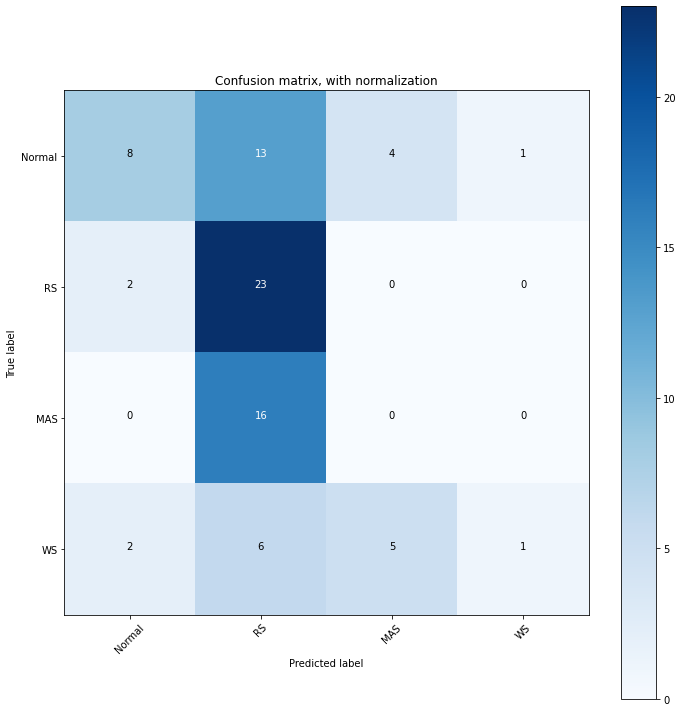

In [75]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix,
                      classes=['Normal', 'RS', 'MAS', 'WS'],
                      normalize=False,
                      title='Confusion matrix, with normalization')

In [76]:
print(classification_report(y2test.argmax(axis=1),
                            ypredict.argmax(axis=1),
                            target_names=['Normal', 'RS', 'MAS', 'WS']))

              precision    recall  f1-score   support

      Normal       0.67      0.31      0.42        26
          RS       0.40      0.92      0.55        25
         MAS       0.00      0.00      0.00        16
          WS       0.50      0.07      0.12        14

    accuracy                           0.40        81
   macro avg       0.39      0.32      0.28        81
weighted avg       0.42      0.40      0.33        81



In [77]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import gradio as gr
import cv2

from sklearn.cluster import KMeans
from skimage.feature import greycomatrix, greycoprops

In [79]:
def preprocessing(img):
    resized = cv2.resize(img, (256, 256), Image.BICUBIC)
    bgr = resized[:, :, ::-1].copy()

    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=0)
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    lab[:, :, 1] = clahe.apply(lab[:, :, 1])
    lab[:, :, 2] = clahe.apply(lab[:, :, 2])
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    res = cv2.fastNlMeansDenoisingColored(bgr, None, 10, 10, 1, 3)
    #bgr = cv2.bilateralFilter(bgr, 5, 1, 1)
    return res


def segmentation(img, online=False):
    pre = preprocessing(img)
    image = cv2.cvtColor(pre, cv2.COLOR_BGR2LAB)
    image = image.reshape((256 * 256, 3))

    clt = KMeans(n_clusters=5)
    labels = clt.fit_predict(image)
    quant = clt.cluster_centers_.astype("uint8")[labels]
    quant = quant.reshape((256, 256, 3))
    res = image.reshape((256, 256, 3))

    if online:
        return quant

    return res


def gray_segmentation(img):
    pre = preprocessing(img)
    segmented = segmentation(pre, True)
    bgr = cv2.cvtColor(segmented, cv2.COLOR_LAB2BGR)
    res = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    return res


def extract(img, online=False):
    image = gray_segmentation(img)
    degs = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
    post = [0, 45, 90, 135]
    val = []
    for i, deg in enumerate(degs):
        GLCM = greycomatrix(image, [3], [deg])
        energy = greycoprops(GLCM, 'energy')[0]
        corr = greycoprops(GLCM, 'correlation')[0]
        hom = greycoprops(GLCM, 'homogeneity')[0]
        contr = greycoprops(GLCM, 'contrast')[0]
        asm = greycoprops(GLCM, 'ASM')[0]

        temp = [post[i], energy[0], corr[0], hom[0], contr[0], asm[0]]
        val.append(temp)

    res = pd.DataFrame(
        np.array(val),
        columns=['Degree', 'Contrast', 'Energy', 'Korelasi', 'ASM', 'Homogenity'],
    )

    if online:
        return np.array(val)
    return res


def predict_(img):
    feature = extract(img, True)[:, 1:]
    # print(feature.shape)
    target_names = ['Normal', 'RS', 'MAS', 'WS']
    feature = feature.reshape((1, 20))
    pred = model.predict(feature)

    return target_names[pred.argmax()]



In [80]:
demo = gr.Blocks()

with demo:
    gr.Markdown('Step by step Demo')
    img_input = gr.Image()
    # with gr.Row():
    img_preprocess = gr.Image()
    button_preprocess = gr.Button('Preprocessing Button')

    # with gr.Row():
    img_segmentation = gr.Image()
    button_segm = gr.Button("Segmentation Button")

    # with gr.Row():
    img_grayscale = gr.Image()
    button_gray = gr.Button("RGB to Grayscale Button")

    # with gr.Row():
    data = gr.DataFrame(
        headers=['Degree', 'Contrast', 'Energy', 'Korelasi', 'ASM', 'Homogenity'],
        # row_count=(1, 'fixed')
    )
    button_extract = gr.Button('Extract Data')

    output = gr.Textbox(label="Prediction Result")
    button_predict = gr.Button('Predict')
    button_preprocess.click(preprocessing, inputs=img_input, outputs=img_preprocess)
    button_segm.click(segmentation, inputs=img_input, outputs=img_segmentation)
    button_gray.click(gray_segmentation, inputs=img_input, outputs=img_grayscale)
    button_extract.click(extract, inputs=img_input, outputs=data)
    button_predict.click(predict_, inputs=img_input, outputs=output)

In [81]:
demo.close()
demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://24850.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f762921acd0>,
 'http://127.0.0.1:7861/',
 'https://24850.gradio.app')